# 0. Import

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

import string
import chardet
import re

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB

# 1. Loading Data

In [2]:
# Loading training data using chardet to determine the encoding correctly
with open("spam.csv", 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

df = pd.read_csv("spam.csv", encoding=encoding)

# 2. Data Cleaning

In [3]:
# Dropping unnecessary and empty columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [4]:
# Rename columns
df.rename(columns={'v1': 'target', 'v2': 'message'}, inplace = 1)

In [5]:
# Encoding categorical features
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [6]:
# Checking for duplicates
df.duplicated().sum()

403

In [7]:
# Deleting duplicates
df.drop_duplicates(keep="first",inplace=True)

In [8]:
# Checking for empty values
df.isnull().sum()

target     0
message    0
dtype: int64

# 3. EDA

In [9]:
# Checking the amount of ham and spam
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

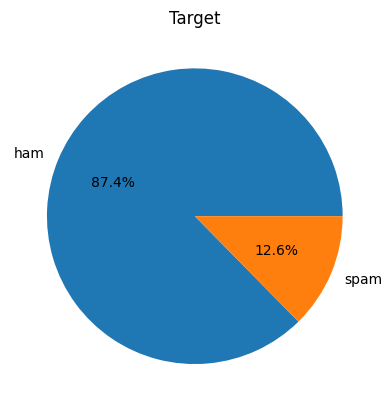

In [10]:
# Building a pie chart of the ham and spam ratio
plt.title("Target")
plt.pie(df["target"].value_counts(), labels=["ham","spam"], autopct="%1.1f%%")
plt.show()

Since we have an imbalance of classes, we will rely on the F-Score as a metric.

# 4. Data Preprocessing

In [11]:
# DataFrame before preprocessing
df.head()

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# Preparation of stopwords
nltk.download('stopwords')
stop_words=stopwords.words('english')
stop_words.extend(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Preprocessing
stemmer=PorterStemmer()
edited_messages=[]

for i in range(0, len(df)):
    # Deleting all characters except letters and numbers
    message = re.sub('[^a-zA-z0-9]', ' ', df.iloc[i]["message"])
    # Reducing the entire text to lowercase
    message = message.lower()
    # Splitting the text into separate words
    message = message.split()
    # Stemming and deleting stop words
    message = [stemmer.stem(word) for word in message if not word in stop_words]
    # Combining processed words back into a string
    message = ' '.join(message)
    edited_messages.append(message)

df['message'] = edited_messages

In [14]:
# DataFrame after preprocessing
df.head()

,target,message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


# 5. Model Building

In [15]:
# Vectorize the messages and divide the sample into X and y
cv=CountVectorizer()
X = cv.fit_transform(df['message']).toarray()
y = df['target']

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [17]:
# Ppreparing a set of models
models = [
    ('LogR', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('GNB', GaussianNB()),
    ('BNB', BernoulliNB()),
    ('DTC', DecisionTreeClassifier()),
    ('RFC', RandomForestClassifier()),
    ('ETC', ExtraTreesClassifier())
]

In [18]:
# Fitting models
results = []
for name, model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  results.append((name, accuracy, f1))

In [19]:
# Building a table with the results of each model
Results = pd.DataFrame(list(results), columns=['Model', 'Accuracy', 'F-Score']).sort_values('F-Score', ascending = False)
Results

,Model,Accuracy,F-Score
0,LogR,0.977756,0.976705
1,SVM,0.974855,0.973489
5,DTC,0.973888,0.972889
4,BNB,0.972921,0.971578
7,ETC,0.971954,0.970363
6,RFC,0.967118,0.965012
2,KNN,0.919729,0.899979
3,GNB,0.867505,0.883372


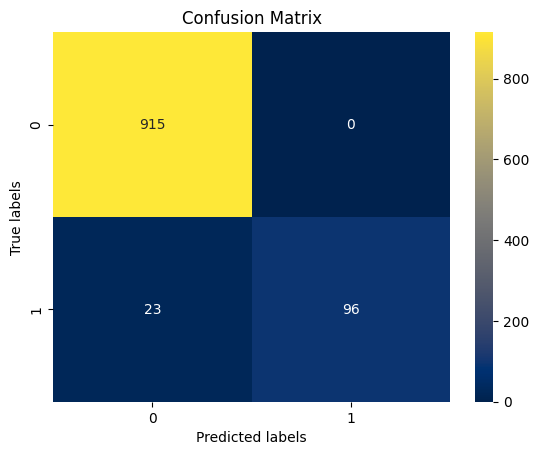

In [20]:
# Building a confusion matrix
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
sbn.heatmap(cm, annot=True, cmap='cividis', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Confusion Matrix")
plt.show()

Despite the initial class imbalance, our model ultimately predicts our target dataset well. The confusion matrix shows minor deviations in the FN (false negatives) area, which is not critical for us. For our task, it is more important to reduce deviations in the FP (false positives) area, and our model meets this requirement effectively.